In [1]:
import os
import random
import numpy as np
import torch
import torchvision
from torchsummary import summary

from fpga_nn_backend.datasets import *
from fpga_nn_backend.training import *
from fpga_nn_backend.evaluation import *
from fpga_nn_backend.models.relu_toy_models import *
from fpga_nn_backend.quantization import *
from fpga_nn_backend.fpga_simple.emulation import *
from fpga_nn_backend.fpga_simple.conversion import *
from fpga_nn_backend.utils import *

In [2]:
print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

PyTorch Version: 1.10.0
Torchvision Version: 0.11.1


In [3]:
data_dir = get_rel_pkg_path("dataset/")
weights_dir = get_rel_pkg_path("weights/")
session_dir = get_rel_pkg_path("sessions/")
models_dir = get_rel_pkg_path("models/")

In [4]:
dataset_type = ImageDatasetType.MNIST

In [5]:
orig_datasets = get_img_dataset(data_dir, dataset_type)

In [6]:
datasets = apply_img_transforms(orig_datasets, dataset_type, flatten=True)

In [7]:
dataloaders = get_dataloaders(datasets, 128, 128, num_workers=0)

In [8]:
input_dim = IMG_DATASET_TO_IMG_SIZE_FLAT[dataset_type]
num_classes = IMG_DATASET_TO_NUM_CLASSES[dataset_type]

model = ReLUToyModel(input_dim, num_classes, layer_dims=[256, 128, 64, 32])
model = model.to(device)

In [9]:
model = QuantWrapper(model)

In [10]:
summary(model, (input_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         QuantStub-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,704
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,768
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 64]           8,192
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,048
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             320
     ReLUToyModel-11                   [-1, 10]               0
      DeQuantStub-12                   [-1, 10]               0
Total params: 244,032
Trainable params: 244,032
Non-trainable params: 0
-------------------------------

In [11]:
# model.load_state_dict(torch.load(os.path.join(weights_dir, r"Experiment 11-18-2021 11-04-36 PM\Weights Best.pckl")))

In [12]:
# model.load_state_dict(torch.load(os.path.join(weights_dir, r"Experiment 11-20-2021 06-39-40 PM\Weights Best.pckl")))

In [13]:
model.load_state_dict(torch.load(os.path.join(weights_dir, r"Experiment 11-23-2021 02-52-17 PM\Weights Best.pckl")))

<All keys matched successfully>

In [14]:
criterion = get_loss()
criterion = criterion.to(device)

In [15]:
model.eval()
model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
#torch.quantization.fuse_modules(model.model.layers, [['0', '1'], ['2', '3'], ['4', '5'], ['6', '7']], inplace=True)
model = torch.quantization.prepare(model)
stats = get_dataloader_stats(dataloaders['test'], model, criterion, device)
model_int8 = torch.quantization.convert(model)

C:\Users\Shahir\anaconda3\envs\py3-dl\lib\site-packages\torch\ao\quantization\observer.py:172: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 20.58it/s]
C:\Users\Shahir\anaconda3\envs\py3-dl\lib\site-packages\torch\ao\quantization\observer.py:886: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  src_bin_begin // dst_bin_width, 0, self.dst_nbins - 1
C:\Users\Shahir\anaconda3\envs\py3-dl\lib\site-packages\torch\ao\quantiza

In [16]:
print("Accuracy:", stats['acc'])

Accuracy: 0.9259


In [17]:
model_int8

QuantWrapper(
  (model): ReLUToyModel(
    (layers): Sequential(
      (0): QuantizedLinear(in_features=784, out_features=256, scale=0.050842445343732834, zero_point=57, qscheme=torch.per_channel_affine)
      (1): ReLU(inplace=True)
      (2): QuantizedLinear(in_features=256, out_features=128, scale=0.06895451247692108, zero_point=27, qscheme=torch.per_channel_affine)
      (3): ReLU(inplace=True)
      (4): QuantizedLinear(in_features=128, out_features=64, scale=0.10227379202842712, zero_point=27, qscheme=torch.per_channel_affine)
      (5): ReLU(inplace=True)
      (6): QuantizedLinear(in_features=64, out_features=32, scale=0.17031508684158325, zero_point=33, qscheme=torch.per_channel_affine)
      (7): ReLU(inplace=True)
      (8): QuantizedLinear(in_features=32, out_features=10, scale=0.40706461668014526, zero_point=64, qscheme=torch.per_channel_affine)
    )
  )
  (quant): Quantize(scale=tensor([0.0079]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

In [18]:
model_int8.model.layers[0].weight().int_repr()

tensor([[ 24, -36,  55,  ..., -34, -51,  18],
        [ 66, -58,  62,  ...,   5, -62, -66],
        [ 60, -87,  -6,  ...,  66,  17, -56],
        ...,
        [-41, -13,  41,  ...,  39,  57, -25],
        [-32,  66, -31,  ..., -48,   5,  49],
        [ 57, -51,  -4,  ..., -30, -18,  -3]], dtype=torch.int8)

In [19]:
model_int8.model.layers[8].bias()

In [20]:
stats = get_dataloader_stats(dataloaders['test'], model_int8, criterion, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 25.83it/s]


In [21]:
print("Accuracy:", stats['acc'])

Accuracy: 0.924


In [22]:
def safe_get_param(param):
    if param is not None:
        return param.int_repr().numpy()
    else:
        return None

In [23]:
converted_nn = ConvertedNN((1, 28, 28))

converted_nn.add_flatten_layer((1, 28, 28), 0, 0)

converted_nn.add_dense_layer((784,), (256,), 0, 0,
    weight=safe_get_param(model_int8.model.layers[0].weight()),
    bias=safe_get_param(model_int8.model.layers[0].bias()))
converted_nn.add_relu_layer((256,), 0, 0)

converted_nn.add_dense_layer((256,), (128,), 0, 0,
    weight=safe_get_param(model_int8.model.layers[2].weight()),
    bias=safe_get_param(model_int8.model.layers[2].bias()))
converted_nn.add_relu_layer((128,), 0, 0)

converted_nn.add_dense_layer((128,), (64,), 0, 0,
    weight=safe_get_param(model_int8.model.layers[4].weight()),
    bias=safe_get_param(model_int8.model.layers[4].bias()))
converted_nn.add_relu_layer((64,), 0, 0)

converted_nn.add_dense_layer((64,), (32,), 0, 0,
    weight=safe_get_param(model_int8.model.layers[6].weight()),
    bias=safe_get_param(model_int8.model.layers[6].bias()))
converted_nn.add_relu_layer((32,), 0, 0)

converted_nn.add_dense_layer((32,), (10,), 0, 0,
    weight=safe_get_param(model_int8.model.layers[8].weight()),
    bias=safe_get_param(model_int8.model.layers[8].bias()))

In [24]:
model_int8.model.layers[8]

QuantizedLinear(in_features=32, out_features=10, scale=0.40706461668014526, zero_point=64, qscheme=torch.per_channel_affine)

In [25]:
converted_nn.get_execution_info()

{'layers': [{'layer_type': <LayerType.FLATTEN: 5>,
   'input_shape': (1, 28, 28),
   'output_shape': (784,),
   'stack_input_indices': (0,),
   'stack_output_index': 0,
   'parameters': None,
   'metadata': None},
  {'layer_type': <LayerType.DENSE: 0>,
   'input_shape': (784,),
   'output_shape': (256,),
   'stack_input_indices': (0,),
   'stack_output_index': 0,
   'parameters': {'weight': 0},
   'metadata': {'has_bias': False}},
  {'layer_type': <LayerType.RELU: 2>,
   'input_shape': (256,),
   'output_shape': (256,),
   'stack_input_indices': (0,),
   'stack_output_index': 0,
   'parameters': None,
   'metadata': None},
  {'layer_type': <LayerType.DENSE: 0>,
   'input_shape': (256,),
   'output_shape': (128,),
   'stack_input_indices': (0,),
   'stack_output_index': 0,
   'parameters': {'weight': 0},
   'metadata': {'has_bias': False}},
  {'layer_type': <LayerType.RELU: 2>,
   'input_shape': (128,),
   'output_shape': (128,),
   'stack_input_indices': (0,),
   'stack_output_index': 

In [26]:
with open("test.coe", 'w') as f:
    f.write(converted_nn.generate_parameter_coe())

In [27]:
info['bank_alloc_len_per_param']

NameError: name 'info' is not defined

In [59]:
h = (np.round((datasets['train'][0][0]).reshape((28,28)).numpy()*255)).astype(np.uint8)

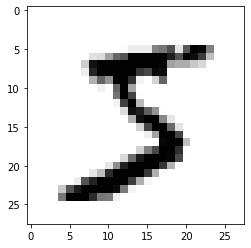

In [60]:
plt.imshow(255 - h, cmap='gray')

In [61]:
h = (np.round((datasets['train'][0][0]).reshape((28,28)).numpy())*255).astype(np.uint8)

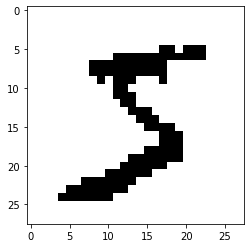

In [62]:
plt.imshow(255 - h, cmap='gray')